In [33]:
import pandas as pd 
import numpy as np 
import talib as tb
import yfinance as yf

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

In [72]:
df_eth = pd.read_csv(r'../data/cryptocsv/eth.csv')

In [35]:
def df_converter(df): 
    df_sp500 = yf.download('^GSPC', 
                      start='2017-11-09', 
                      end='2022-04-26', 
                      progress=False)
    df_dollar = yf.download('DX=F', 
                      start='2017-11-09', 
                      end='2022-04-26', 
                      progress=False)
    # clearing dollar and sp500 df
    df_dollar.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)
    df_dollar.rename(columns={"Close": "dollar_close"}, inplace=True)
    df_sp500.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)
    df_sp500.rename(columns={"Close": "sp500_close"}, inplace=True)
    # clearing general df
    df_eth.drop('Unnamed: 0', axis=1, inplace=True)
    df_eth.drop('adj_close', axis=1, inplace=True)
    df_eth.set_index('Date', inplace=True)
    df_eth.index = df_eth.index.astype('datetime64[ns]')
    df_eth.dropna(inplace=True)
    # MA df
    df_ma = df['close'].to_frame()
    df_ma['SMA30'] = df_ma['close'].rolling(30).mean()
    df_ma['CMA30'] = df_ma['close'].expanding().mean()
    df_ma['EMA30'] = tb.EMA(df_ma['close'], timeperiod=30)
    df_ma.dropna(inplace=True)
    # Stoch df
    slowk, slowd = tb.STOCH(df["high"], df["low"], df["close"], fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df_stoch = pd.DataFrame(index=df_eth.index,
                                data={"slowk": slowk,
                                    "slowd": slowd})
    df_stoch.dropna(inplace=True)
    # for later use in the concat
    stoch_c = ['slowk', 'slowd']
    # MACD df 
    macd, macdsignal, macdhist = tb.MACD(df.close, fastperiod=12, slowperiod=26, signalperiod=9)
    df_macd = pd.DataFrame(index=df_eth.index,
                            data={"macd": macd,
                                  "macdsignal": macdsignal,
                                  "macdhist": macdhist})
    df_macd.dropna(inplace=True)
    # for later use in the concat
    macd_c = ['macd', 'macdsignal', 'macdhist']
    # bb df
    upper, middle, lower = tb.BBANDS(df["close"], timeperiod=30)
    df_bands = pd.DataFrame(index=df.index,
                                data={"bb_low": lower,
                                    "bb_ma": middle,
                                    "bb_high": upper})
    df_bands.dropna(inplace=True)
    # for later use in the concat
    bands_c = ['bb_low', 'bb_ma', 'bb_high']
    # rsi df
    rsi = tb.RSI(df_eth['close'], timeperiod=30)
    df_rsi = pd.DataFrame(index=df.index,
                            data={"close": df['close'],
                                  "rsi": rsi})

    df_rsi.dropna(inplace=True)
    #stdev df
    stdev = tb.STDDEV(df['close'], timeperiod=30, nbdev=1)
    df_stdev = pd.DataFrame(index=df.index,
                            data={"close": df['close'],
                                  "stdev": stdev})
    df_stdev.dropna(inplace=True)
    # adx df
    adx = tb.ADX(df['high'], df['low'], df['close'], timeperiod=20)
    df_adx = pd.DataFrame(index=df.index,
                                data={"close": df['close'],
                                    "adx": adx})

    df_adx.dropna(inplace=True)

    # concat 
    result =pd.concat([df, df_ma[['SMA30','CMA30','EMA30']], df_adx['adx'], df_bands[bands_c], df_macd[macd_c], df_rsi['rsi'], df_stdev['stdev'], df_stoch[stoch_c], df_dollar['dollar_close'], df_sp500['sp500_close']], axis=1)
    result.dropna(inplace=True)

    return result 
    


# Creating Indicators

In [37]:
df_sp500 = yf.download('^GSPC', 
                      start='2017-11-09', 
                      end='2022-04-26', 
                      progress=False,
)

df_dollar = yf.download('DX=F', 
                      start='2017-11-09', 
                      end='2022-04-26', 
                      progress=False,
)
df_dollar.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,94.849998,94.864998,94.305000,94.351997,94.351997,22013
2017-11-10,94.364998,94.555000,94.154999,94.278000,94.278000,10711
2017-11-13,94.355003,94.544998,94.309998,94.388000,94.388000,27436
2017-11-14,94.404999,94.440002,93.639999,93.723000,93.723000,25251
2017-11-15,93.769997,93.800003,93.305000,93.725998,93.725998,12190
2017-11-16,93.785004,93.915001,93.690002,93.853996,93.853996,12190
2017-11-17,93.714996,93.845001,93.419998,93.574997,93.574997,19683
2017-11-20,93.730003,94.019997,93.485001,93.997002,93.997002,11698
2017-11-21,93.945000,94.084999,93.794998,93.876999,93.876999,24893


In [38]:
df_dollar.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)
df_dollar.rename(columns={"Close": "dollar_close"}, inplace=True)
df_sp500.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)
df_sp500.rename(columns={"Close": "sp500_close"}, inplace=True)


In [39]:
df_eth[~(df_eth['adj_close'].isna())].head(10)

,Unnamed: 0,Date,adj_close,close,low,high,open,volume
197,197,2017-11-09,320.884003,320.884003,307.056000,329.451996,308.644989,8.932500e+08
198,198,2017-11-10,299.252991,299.252991,294.541992,324.717987,320.670990,8.859860e+08
199,199,2017-11-11,314.681000,314.681000,298.191986,319.453003,298.585999,8.423010e+08
200,200,2017-11-12,307.907990,307.907990,298.513000,319.153015,314.690002,1.613480e+09
201,201,2017-11-13,316.716003,316.716003,307.024994,328.415009,307.024994,1.041890e+09
202,202,2017-11-14,337.631012,337.631012,316.763000,340.177002,316.763000,1.069680e+09
203,203,2017-11-15,333.356995,333.356995,329.812988,340.911987,337.963989,7.226660e+08
204,204,2017-11-16,330.924011,330.924011,323.605988,336.158997,333.442993,7.972540e+08
205,205,2017-11-17,332.394012,332.394012,327.523010,334.963989,330.166992,6.217330e+08
206,206,2017-11-18,347.612000,347.612000,327.687012,349.615997,331.980011,6.496390e+08


In [40]:
df_eth.drop('Unnamed: 0', axis=1, inplace=True)
df_eth.drop('adj_close', axis=1, inplace=True)
df_eth.set_index('Date', inplace=True)
df_eth.index = df_eth.index.astype('datetime64[ns]')
df_eth.dropna(inplace=True)

In [41]:
df_eth

,close,low,high,open,volume
Date,,,,,
2017-11-09,320.884003,307.056000,329.451996,308.644989,8.932500e+08
2017-11-10,299.252991,294.541992,324.717987,320.670990,8.859860e+08
2017-11-11,314.681000,298.191986,319.453003,298.585999,8.423010e+08
2017-11-12,307.907990,298.513000,319.153015,314.690002,1.613480e+09
2017-11-13,316.716003,307.024994,328.415009,307.024994,1.041890e+09
...,...,...,...,...,...
2022-04-21,2987.480713,2962.410400,3173.451416,3077.829346,2.078359e+10
2022-04-22,2964.835693,2942.358643,3024.854492,2986.938721,1.678280e+10
2022-04-23,2938.114014,2926.740234,2975.322754,2964.802246,9.116956e+09


## Moving Average

In [42]:
eth_ma = df_eth['close'].to_frame()
eth_ma['SMA30'] = eth_ma['close'].rolling(30).mean()
eth_ma['CMA30'] = eth_ma['close'].expanding().mean()
eth_ma['EMA30'] = tb.EMA(df_eth['close'], timeperiod=30)
eth_ma.dropna(inplace=True)
eth_ma

,close,SMA30,CMA30,EMA30
Date,,,,
2017-12-08,456.031006,400.082003,400.082003,400.082003
2017-12-09,473.502014,405.169270,402.450390,404.818778
2017-12-10,441.721008,409.918204,403.677597,407.199567
2017-12-11,515.135986,416.600037,407.055124,414.163207
2017-12-12,651.431030,428.050805,414.242651,429.470808
...,...,...,...,...
2022-04-21,2987.480713,3199.351164,1063.847074,3095.944448
2022-04-22,2964.835693,3197.143449,1065.016194,3087.485819
2022-04-23,2938.114014,3191.478516,1066.167452,3077.848928


In [43]:
fig = px.line(eth_ma, x=eth_ma.index, y =['close', 'SMA30', 'CMA30', 'EMA30'],  color_discrete_sequence=px.colors.qualitative.G10)
fig

## Stochastic Oscillator

https://www.investopedia.com/terms/s/stochasticoscillator.asp

1. A stochastic oscillator is a popular technical indicator for generating overbought and oversold signals.
2. Buy/Sell when both K and D are below 20% or above 80%
3. Stochastic oscillators tend to vary around some mean price level, since they rely on an asset's price history.

In [44]:
slowk, slowd = tb.STOCH(df_eth["high"], df_eth["low"], df_eth["close"], fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
eth_stoch = pd.DataFrame(index=df_eth.index,
                            data={"slowk": slowk,
                                  "slowd": slowd})

eth_stoch.dropna(inplace=True)


eth_stoch

,slowk,slowd
Date,,
2017-11-17,77.873856,80.783803
2017-11-18,81.735528,81.334123
2017-11-19,77.770765,79.126716
2017-11-20,82.435804,80.647365
2017-11-21,75.518558,78.575042
...,...,...
2022-04-21,64.679521,64.653946
2022-04-22,42.828174,61.069701
2022-04-23,21.151273,42.886322


In [45]:
def signal(k, d): 
    if (d <= 20 and k<=20) or (d >=80 and k>=80): 
        return 1
    else: return 0

In [46]:
eth_stoch['stoch_signal'] = eth_stoch.apply(lambda x: signal(x.slowk, x.slowd), axis=1)

In [47]:
fig = px.bar(eth_stoch, x=eth_stoch.index, y =['stoch_signal'],  color_discrete_sequence=px.colors.qualitative.G10)
fig

In [48]:
# for later use in the concat
stoch_c = ['slowk', 'slowd']

## MACD - Moving Average Convergence/Divergence

https://www.investopedia.com/terms/m/macd.asp

1. MACD triggers technical signals when it crosses above (to buy) or below (to sell) its signal line.
2. The speed of crossovers is also taken as a signal of a market is overbought or oversold.
3. MACD helps investors understand whether the bullish or bearish movement in the price is strengthening or weakening.

In [49]:
macd, macdsignal, macdhist = tb.MACD(df_eth.close, fastperiod=12, slowperiod=26, signalperiod=9)

In [50]:
eth_macd = pd.DataFrame(index=df_eth.index,
                            data={"macd": macd,
                                  "macdsignal": macdsignal,
                                  "macdhist": macdhist})

eth_macd.dropna(inplace=True)
eth_macd


,macd,macdsignal,macdhist
Date,,,
2017-12-12,53.550952,50.810936,2.740015
2017-12-13,66.384639,53.925677,12.458962
2017-12-14,75.128503,58.166242,16.962261
2017-12-15,80.216096,62.576213,17.639883
2017-12-16,84.226156,66.906201,17.319955
...,...,...,...
2022-04-21,-21.003927,5.781681,-26.785609
2022-04-22,-28.661926,-1.107040,-27.554886
2022-04-23,-36.466794,-8.178991,-28.287803


In [51]:
# for later use in the concat
macd_c = ['macd', 'macdsignal', 'macdhist']

## Bollinger Bands

In [52]:
upper, middle, lower = tb.BBANDS(df_eth["close"], timeperiod=30)
eth_bands = pd.DataFrame(index=df_eth.index,
                            data={"bb_low": lower,
                                  "bb_ma": middle,
                                  "bb_high": upper})
eth_bands.dropna(inplace=True)
eth_bands

,bb_low,bb_ma,bb_high
Date,,,
2017-12-08,272.823019,400.082003,527.340986
2017-12-09,278.781964,405.169270,531.556575
2017-12-10,289.228888,409.918204,530.607520
2017-12-11,295.546009,416.600037,537.654065
2017-12-12,286.958109,428.050805,569.143500
...,...,...,...
2022-04-21,2866.562736,3199.351164,3532.139591
2022-04-22,2859.081758,3197.143449,3535.205140
2022-04-23,2842.128490,3191.478516,3540.828542


In [53]:
# for later use in the concat
bands_c = ['bb_low', 'bb_ma', 'bb_high']

## Relative strength index (RSI)

https://www.investopedia.com/terms/r/rsi.asp

1. The RSI provides technical traders with signals about bullish and bearish price momentum, and it is often plotted beneath the graph of an asset’s price.
2. An asset is usually considered overbought when the RSI is above 70% and oversold when it is below 30%.

In [54]:
rsi = tb.RSI(df_eth['close'], timeperiod=30)

In [55]:
eth_rsi = pd.DataFrame(index=df_eth.index,
                            data={"close": df_eth['close'],
                                  "rsi": rsi})

eth_rsi.dropna(inplace=True)
eth_rsi.head(10)

,close,rsi
Date,,
2017-12-09,473.502014,67.039114
2017-12-10,441.721008,62.454273
2017-12-11,515.135986,67.728465
2017-12-12,651.431030,74.584993
2017-12-13,702.767029,76.528106
2017-12-14,695.815979,75.717230
2017-12-15,684.447998,74.383808
2017-12-16,696.208984,74.857681
2017-12-17,719.974976,75.793755


In [56]:
fig = px.line(eth_rsi, x=eth_rsi.index, y =['close', 'rsi'],  color_discrete_sequence=px.colors.qualitative.G10)
fig

## Fibonacci retracement

## Ichimoku cloud

## Standard deviation

In [57]:
stdev = tb.STDDEV(df_eth['close'], timeperiod=30, nbdev=1)

In [58]:
eth_stdev = pd.DataFrame(index=df_eth.index,
                            data={"close": df_eth['close'],
                                  "stdev": stdev})

eth_stdev.dropna(inplace=True)
eth_stdev


,close,stdev
Date,,
2017-12-08,456.031006,63.629492
2017-12-09,473.502014,63.193653
2017-12-10,441.721008,60.344658
2017-12-11,515.135986,60.527014
2017-12-12,651.431030,70.546348
...,...,...
2022-04-21,2987.480713,166.394214
2022-04-22,2964.835693,169.030846
2022-04-23,2938.114014,174.675013


## Average directional index

https://www.investopedia.com/terms/a/adx.asp#:~:text=The%20average%20directional%20index%20(ADX)%20is%20a%20technical%20analysis%20indicator,positive%20directional%20indicator%20(%2BDI).

1. The ADX makes use of a positive (+DI) and negative (-DI) directional indicator in addition to the trendline.
2. The trend has strength when ADX is above 25; the trend is weak or the price is trendless when ADX is below 20, according to Wilder.
3. Non-trending doesn't mean the price isn't moving. It may not be, but the price could also be making a trend change or is too volatile for a clear direction to be present.

In [59]:
adx = tb.ADX(df_eth['high'], df_eth['low'], df_eth['close'], timeperiod=20)

In [60]:
eth_adx = pd.DataFrame(index=df_eth.index,
                            data={"close": df_eth['close'],
                                  "adx": adx})

eth_adx.dropna(inplace=True)
eth_adx

,close,adx
Date,,
2017-12-18,794.645020,37.573268
2017-12-19,826.822998,38.843567
2017-12-20,819.085999,39.647736
2017-12-21,821.062988,40.545057
2017-12-22,674.859985,39.001209
...,...,...
2022-04-21,2987.480713,13.298290
2022-04-22,2964.835693,13.319277
2022-04-23,2938.114014,13.400342


## Creating full dataframe 

First, know the most recent time table present

In [61]:
df_dollar['dollar_close']

Date
2017-11-09     94.351997
2017-11-10     94.278000
2017-11-13     94.388000
2017-11-14     93.723000
2017-11-15     93.725998
                 ...    
2022-04-19    100.963997
2022-04-20    100.417000
2022-04-21    100.613998
2022-04-22    101.212997
2022-04-25    101.768997
Name: dollar_close, Length: 1122, dtype: float64

In [62]:
result =pd.concat([df_eth, eth_ma[['SMA30','CMA30','EMA30']], eth_adx['adx'], eth_bands[bands_c], eth_macd[macd_c], eth_rsi['rsi'], eth_stdev['stdev'], eth_stoch[stoch_c], df_dollar['dollar_close'], df_sp500['sp500_close']], axis=1)

In [63]:
result.dropna(inplace=True)

In [64]:
result

,close,low,high,open,volume,SMA30,CMA30,EMA30,adx,bb_low,...,bb_high,macd,macdsignal,macdhist,rsi,stdev,slowk,slowd,dollar_close,sp500_close
Date,,,,,,,,,,,,,,,,,,,,,
2017-12-18,794.645020,689.231018,803.927979,721.731995,3.249230e+09,504.558336,459.452753,524.883146,37.573268,266.921141,...,742.195531,96.449095,76.238422,20.210674,78.406740,118.818597,83.564367,80.236160,93.519997,2690.159912
2017-12-19,826.822998,785.341980,881.943970,793.901001,4.096550e+09,520.306237,468.413003,544.363136,38.843567,262.779886,...,777.832587,104.298380,81.850413,22.447966,79.398146,128.763175,84.151665,81.894261,93.027000,2681.469971
2017-12-20,819.085999,756.004028,845.062012,827.515991,3.969940e+09,535.384770,476.762360,562.087192,39.647736,263.046381,...,807.723158,108.642322,87.208795,21.433527,78.501649,136.169194,80.848991,82.855007,92.890999,2679.250000
2017-12-21,821.062988,792.689026,880.543030,820.236023,3.569060e+09,550.740169,484.769351,578.795308,40.545057,267.854902,...,833.625437,110.965315,91.960099,19.005216,78.565623,141.442634,72.010593,79.003750,92.862000,2684.570068
2017-12-22,674.859985,543.762024,827.682983,822.643005,4.977710e+09,560.547102,489.089593,584.993029,39.001209,281.555817,...,839.538387,99.857844,93.539648,6.318196,63.996569,139.495643,58.641970,70.500518,92.924004,2683.340088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-19,3104.106445,3035.535156,3125.084229,3057.570312,1.415604e+10,3192.880534,1061.420991,3105.195662,13.767477,2844.229766,...,3541.531302,-12.305159,18.905029,-31.210188,50.764084,174.325384,53.580909,42.326160,100.963997,4462.209961
2022-04-20,3077.745850,3045.288330,3157.885742,3103.935059,1.554736e+10,3198.872843,1062.662570,3103.424706,13.357223,2864.828815,...,3532.916871,-13.229700,12.478083,-25.707783,50.191571,167.022014,75.701409,57.225552,100.417000,4459.450195
2022-04-21,2987.480713,2962.410400,3173.451416,3077.829346,2.078359e+10,3199.351164,1063.847074,3095.944448,13.298290,2866.562736,...,3532.139591,-21.003927,5.781681,-26.785609,48.263444,166.394214,64.679521,64.653946,100.613998,4393.660156


# Correlation Matrix

In [303]:
result = pd.read_csv(r'../data/cryptoInd/eth_ind.csv', index_col='Date')

## Scaling

ASK TEACHER: should i do this?

In [304]:
scaled_df = result.copy()
scaler = StandardScaler()
scaled_feat = scaler.fit_transform(result)
scaled_df = pd.DataFrame(scaled_feat, index = result.index, columns=result.columns)
scaled_df.head()

,adj_close,close,low,high,open,volume,SMA30,CMA30,EMA30,adx,...,bb_high,macd,macdsignal,macdhist,rsi,stdev,slowk,slowd,dollar_close,sp500_close
Date,,,,,,,,,,,,,,,,,,,,,
2017-12-18,-0.229069,-0.229069,-0.288345,-0.243544,-0.286521,-0.871515,-0.449025,-0.327317,-0.434275,1.361365,...,-0.366933,1.005854,0.811232,0.779552,2.624118,0.069517,1.172486,1.113350,-0.461681,-0.986639
2017-12-19,-0.203679,-0.203679,-0.209516,-0.184065,-0.229629,-0.798785,-0.436319,-0.283641,-0.418507,1.508224,...,-0.342642,1.099279,0.882185,0.865283,2.721068,0.145377,1.196001,1.185033,-0.626366,-0.999314
2017-12-20,-0.209784,-0.209784,-0.233578,-0.212184,-0.203129,-0.809653,-0.424154,-0.242942,-0.404160,1.601195,...,-0.322268,1.150983,0.949931,0.826411,2.633399,0.201872,1.063764,1.226568,-0.671797,-1.002552
2017-12-21,-0.208224,-0.208224,-0.203490,-0.185133,-0.208868,-0.844062,-0.411765,-0.203912,-0.390636,1.704934,...,-0.304612,1.178632,1.010002,0.733360,2.639655,0.242099,0.709883,1.060071,-0.681485,-0.994792
2017-12-22,-0.323585,-0.323585,-0.407657,-0.225433,-0.206971,-0.723151,-0.403853,-0.182853,-0.385619,1.526449,...,-0.300582,1.046426,1.029972,0.247205,1.214940,0.227246,0.174616,0.692459,-0.660772,-0.996587


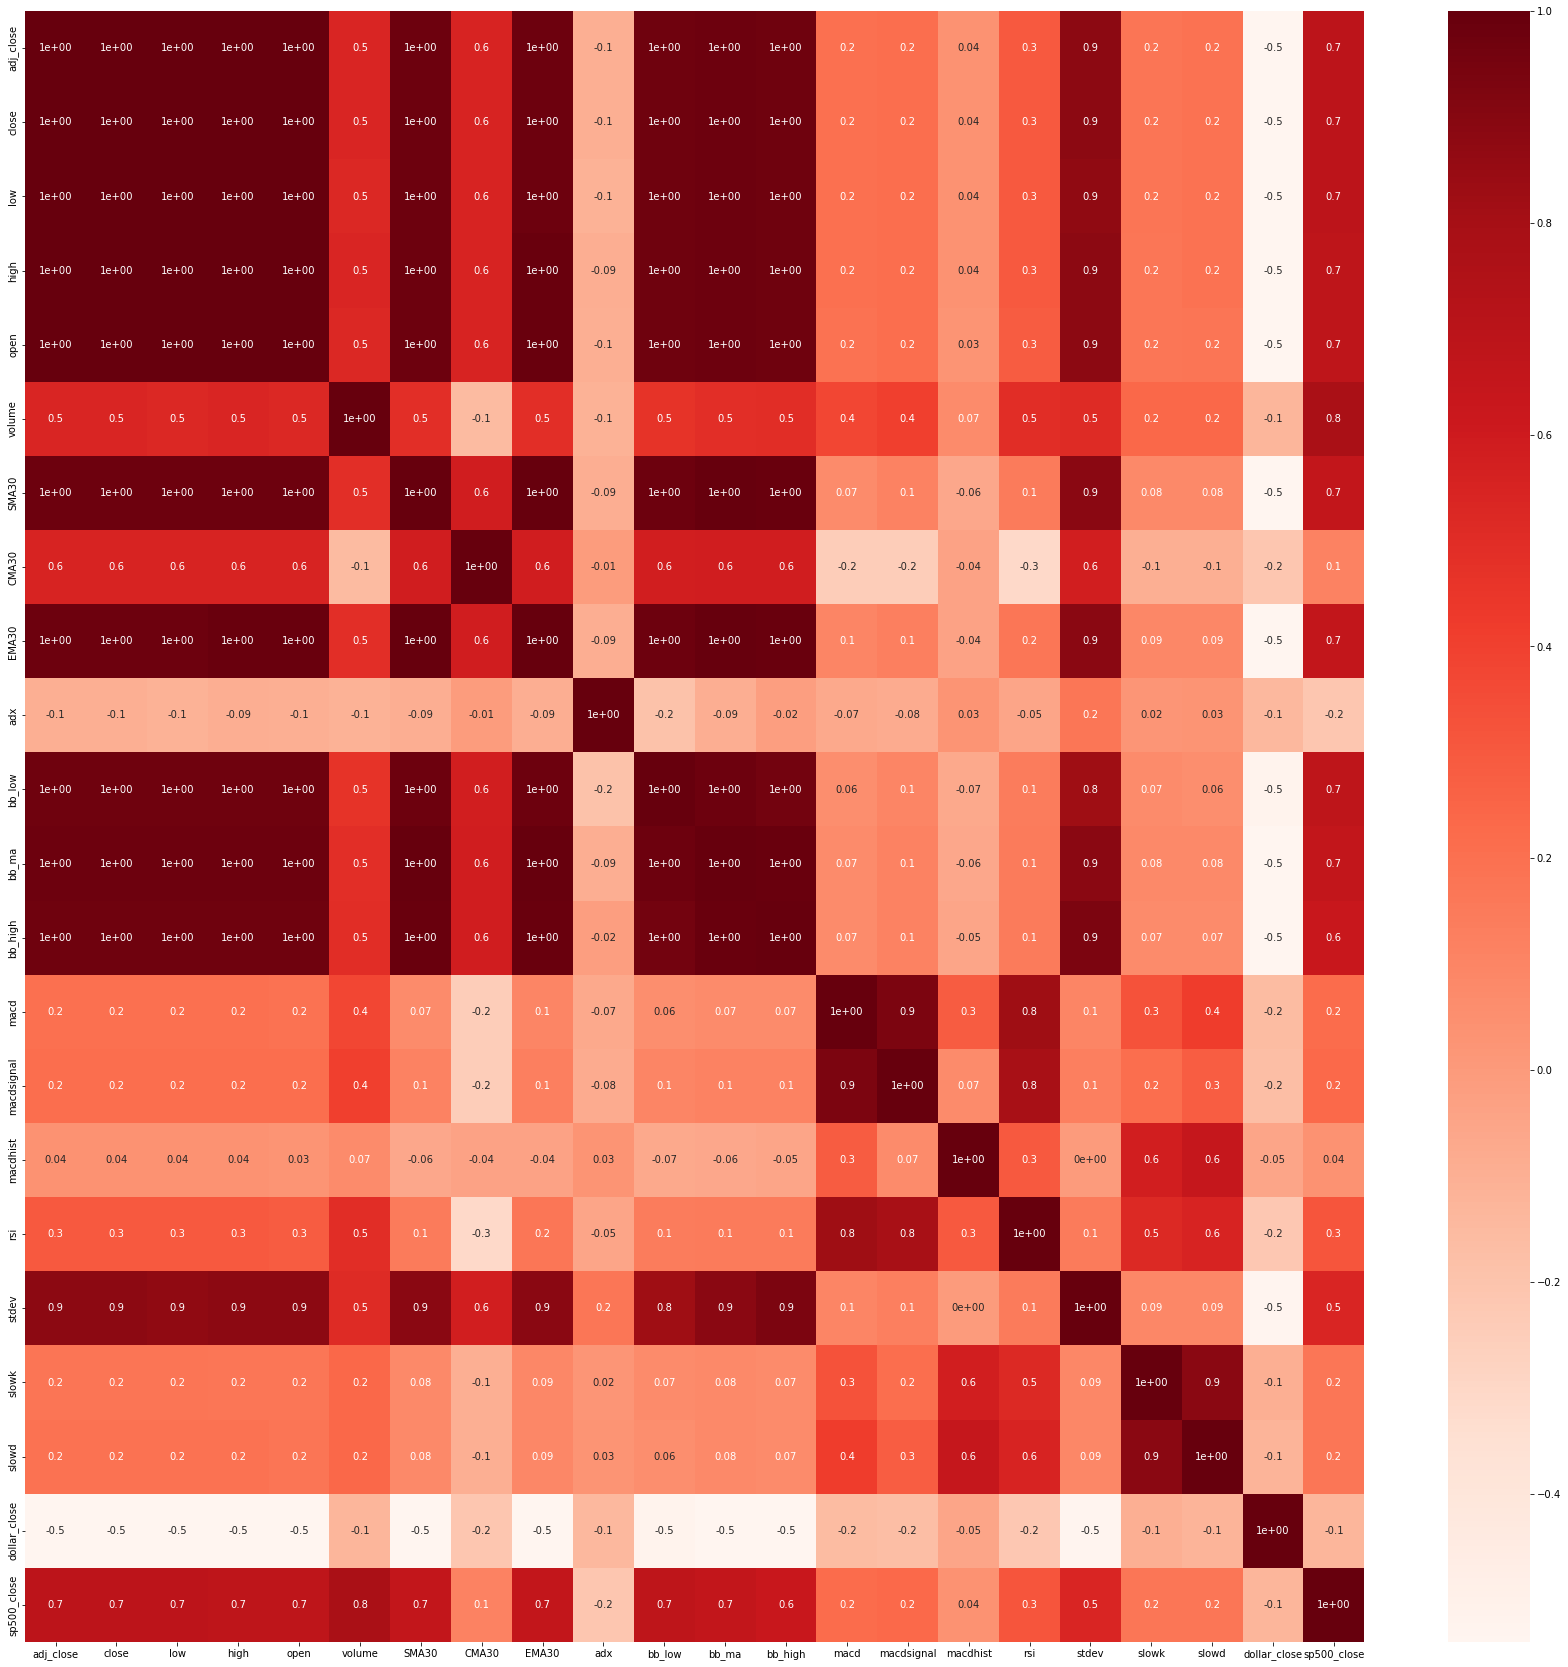

In [305]:
# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(scaled_df.corr(method="spearman"), decimals=2)

def cor_heatmap(cor):
    plt.figure(figsize=(30,30))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()


cor_heatmap(corr)

As we can see high, low, open, SMA30, EMA30 and the Bollinger Bands pretty much all tell the same information and are highly correlated. These variables will then be removed. 

In [306]:
scaled_df.columns

Index(['adj_close', 'close', 'low', 'high', 'open', 'volume', 'SMA30', 'CMA30',
       'EMA30', 'adx', 'bb_low', 'bb_ma', 'bb_high', 'macd', 'macdsignal',
       'macdhist', 'rsi', 'stdev', 'slowk', 'slowd', 'dollar_close',
       'sp500_close'],
      dtype='object')

In [307]:
scaled_df.drop(['low', 'open','SMA30', 'EMA30','bb_low', 'bb_ma', 'bb_high', 'stdev', 'adj_close', 'macdsignal'], axis=1, inplace=True)

# Timeseries CV and Sliding window 

## TimeSeries CV

In [197]:
scaled_df.columns

Index(['close', 'high', 'volume', 'CMA30', 'adx', 'macd', 'macdhist', 'rsi',
       'slowk', 'slowd', 'dollar_close', 'sp500_close'],
      dtype='object')

In [238]:
y = result['close']
X = scaled_df.drop(['close'], axis=1)

In [211]:
#Splitting to Training set and Test set
timesplit= TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(X):
        X_train, X_test = X[:len(train_index)], X[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = y[:len(train_index)].values.ravel(), y[len(train_index): (len(train_index)+len(test_index))].values.ravel()

## Hand-Made Sliding Window

In [373]:
y = result
y.reset_index(inplace=True)
X = scaled_df.drop(['close'], axis=1)
X.reset_index(inplace=True)
y['Date'] = pd.to_datetime(y['Date']).dt.date

In [374]:
def train_test_split_time_series(data, num_df, column_date):
    #data: data frame to split
    #num_df: number of differente splits
    #column_date: name of the column that has the Date info
    data[column_date] = pd.to_datetime(data[column_date]).dt.date
    date_split=[]
    max_date = data[column_date].max()
    min_date = data[column_date].min()
    range_date = max_date-min_date
    split_criteria = 0.2/(num_df-1)
    train = 0.6
    test = 0.8
    inicial = 0
    for i in range(num_df):
        list_to_add=[]
        list_to_add.append((min_date + range_date*inicial))
        list_to_add.append((min_date + range_date*train))
        list_to_add.append((min_date + range_date*test))
        train = train + split_criteria
        test = test + split_criteria
        inicial = inicial + split_criteria

        date_split.append(list_to_add)
    
    
    return date_split

In [375]:
date = train_test_split_time_series(X, num_df=3, column_date='Date')

In [376]:
date

[[datetime.date(2017, 12, 18),
  datetime.date(2020, 7, 28),
  datetime.date(2021, 6, 11)],
 [datetime.date(2018, 5, 25),
  datetime.date(2021, 1, 3),
  datetime.date(2021, 11, 17)],
 [datetime.date(2018, 10, 31),
  datetime.date(2021, 6, 11),
  datetime.date(2022, 4, 25)]]

In [377]:
train_1 = X[(X['Date'] >= date[0][0]) & (X['Date'] < date[0][1])]
test_1 = X[(X['Date'] >= date[0][1]) & (X['Date'] < date[0][2])]

y_train_1 = y[(y['Date'] >= date[0][0]) & (y['Date'] < date[0][1])]
y_test_1 = y[(y['Date'] >= date[0][1]) & (y['Date'] < date[0][2])]

In [379]:
def date_to_index(col_name, *args):
    for df in args:
        df.set_index(col_name, inplace = True)

In [380]:
date_to_index('Date', train_1, test_1)

In [381]:
y_train_1 = y_train_1['close']
y_test_1= y_test_1['close']

# Models

## Functions To Apply the Models 

In [384]:
# Models
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [386]:
def show_results(df,X_train, X_test, y_train, y_test, *args):
    """
    Receive an empty dataframe and the different models and call the function avg_score
    """
    preds = [y_test]
    count = 0
    # for each model passed as argument
    for arg in args:
        # applies the model
        model_fit = arg.fit(X_train, y_train)
        # predicts training
        y_pred_test = model_fit.predict(X_test)
        # evaluate predictions
        mae = mean_absolute_error(y_test, y_pred_test)
        mse = mean_squared_error(y_test, y_pred_test)
        r2 = r2_score(y_test, y_pred_test)
        preds.append(y_pred_test)
        # store the results in the right row
        df.iloc[count] = mae, mse, r2
        count+=1
    
    fig = px.line(X_test, x = X_test.index, y = preds)
    fig.show()
    return df

## Random Forest

In [387]:
rf_se = RandomForestRegressor(random_state=10,criterion='squared_error')
rf_ae = RandomForestRegressor(random_state=10,criterion='absolute_error')
rf_poisson = RandomForestRegressor(random_state=10,criterion='poisson')


In [388]:
df = pd.DataFrame(columns = ['MAE', 'MSE', 'R2'], index = ['squared','absolute', 'poisson'])
show_results(df, train_1, test_1, y_train_1, y_test_1,rf_se, rf_ae,rf_poisson)



,MAE,MSE,R2
squared,488.764589,703309.608482,0.258139
absolute,482.801794,697195.262187,0.264589
poisson,473.737385,654976.813614,0.309121


In [216]:
rf_se5 = RandomForestRegressor(random_state=10,criterion='squared_error', max_depth=5,n_estimators=300)
rf_se20 = RandomForestRegressor(random_state=10,criterion='squared_error', max_depth=20, n_estimators=2000)
rf_se50 = RandomForestRegressor(random_state=10,criterion='squared_error', max_depth=50 ,n_estimators=3000)


In [217]:
df = pd.DataFrame(columns = ['MAE', 'MSE', 'R2'], index = ['300','2000', '3000'])
show_results(df,rf_se5, rf_se20,rf_se50)

,MAE,MSE,R2
300,88.002463,13851.744276,0.947589
2000,79.345987,11075.930898,0.958092
3000,78.850352,11041.199991,0.958223


## Gradient Boost

In [139]:
gb_mae = GradientBoostingRegressor(random_state = 10 , loss='absolute_error', n_estimators = 130)
gb_mse = GradientBoostingRegressor(random_state = 10 , criterion='squared_error', n_estimators = 130)


<AxesSubplot:title={'center':'Feature Importances'}>

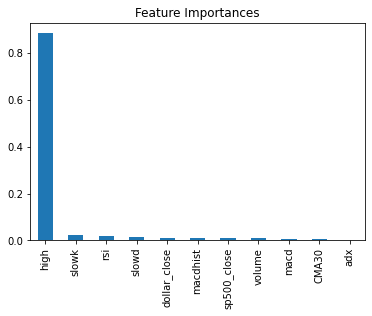

In [140]:
# applies the model
model_fit = gb_mae.fit(X_train, y_train)
# predicts training
y_pred_test = model_fit.predict(X_test)
# evaluate predictions
mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

feat_imp = pd.Series(model_fit.feature_importances_, X_train.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')

In [141]:
df = pd.DataFrame(columns = ['MAE', 'MSE', 'R2'], index = ['mae','mse'])
show_results(df,gb_mae, gb_mse)

,MAE,MSE,R2
mae,296.56587,172199.040309,0.348451
mse,102.530472,16691.331605,0.936845


In [143]:
gb_200 = GradientBoostingRegressor(random_state = 10 , loss='absolute_error', n_estimators = 200)
gb_500 = GradientBoostingRegressor(random_state = 10 , loss='absolute_error', n_estimators = 500)
gb_1500 = GradientBoostingRegressor(random_state = 10 , loss='absolute_error', n_estimators = 1500)
df = pd.DataFrame(columns = ['MAE', 'MSE', 'R2'], index = ['200','500', '1500'])
show_results(df,gb_200, gb_500, gb_1500)

,MAE,MSE,R2
200,296.590188,172379.533805,0.347768
500,284.55981,159848.373038,0.395182
1500,279.564689,156201.095226,0.408982


In [144]:
gb_5 = GradientBoostingRegressor(random_state = 10 , loss='absolute_error', n_estimators = 55,min_samples_split=5)
gb_10 = GradientBoostingRegressor(random_state = 10 , loss='absolute_error', n_estimators = 55,min_samples_split=10)
gb_50 = GradientBoostingRegressor(random_state = 10 , loss='absolute_error', n_estimators = 55,min_samples_split=50)
df = pd.DataFrame(columns = ['MAE', 'MSE', 'R2'], index = ['5','10', '50'])
show_results(df,gb_5, gb_10,gb_50)

,MAE,MSE,R2
5,298.891909,174645.292894,0.339195
10,293.729228,166425.999097,0.370294
50,272.355078,139674.493585,0.471514


In [145]:
gb_01 = GradientBoostingRegressor(random_state = 10 , loss='absolute_error', n_estimators = 55,min_samples_split=10, learning_rate=0.05)
gb_005 = GradientBoostingRegressor(random_state = 10 , loss='absolute_error', n_estimators = 55,min_samples_split=10, learning_rate=0.1)
gb_02 = GradientBoostingRegressor(random_state = 10 , loss='absolute_error', n_estimators = 55,min_samples_split=10, learning_rate=0.2)
df = pd.DataFrame(columns = ['MAE', 'MSE', 'R2'], index = ['0.05','0.1', '0.2'])
show_results(df,gb_005, gb_01, gb_02)

,MAE,MSE,R2
0.05,293.729228,166425.999097,0.370294
0.1,462.897667,364612.857229,-0.379585
0.2,263.319963,147378.290408,0.442365


## XGBoost

In [146]:
xgb_mae = GradientBoostingRegressor(random_state = 10 , loss='absolute_error', n_estimators = 130)
xgb_mse = GradientBoostingRegressor(random_state = 10 , criterion='squared_error', n_estimators = 130)

<AxesSubplot:title={'center':'Feature Importances'}>

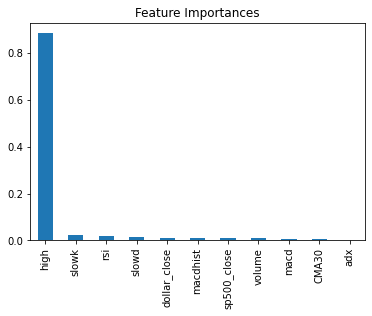

In [147]:
# applies the model
model_fit = gb_mae.fit(X_train, y_train)
# predicts training
y_pred_test = model_fit.predict(X_test)
# evaluate predictions
mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

feat_imp = pd.Series(model_fit.feature_importances_, X_train.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')